# 03: Velocity inversion

# NOTE: still need to organize this code more

In [1]:
#| default_exp invert

In [2]:
#| hide
from nbdev.showdoc import *
import nbdev 
from nbdev import nbdev_export

In [3]:
#| export
import numpy as np
import pyproj
import matplotlib.path as path
import s3fs
import zarr
import matplotlib.pyplot as plt
import scipy
from datetime import timedelta
from tqdm import tqdm
import xarray as xr
import re
import pandas as pd
import geopandas as gpd
import matplotlib.path as mplp
import ipyleaflet as ipyl
from ipyleaflet import WMSLayer
import ipywidgets as ipyw
import json
import pandas as pd
from ipyleaflet import Map, WMSLayer, basemaps, GeoData
from ipywidgets import HTML
from owslib.wms import WebMapService

In [4]:
#| export
from ITS_LIVE_TOOL import obj_setup, interactive

In [5]:
#| export
urls = []

In [10]:
#| export
data_map = interactive.Widget()

In [11]:
data_map.display()

In [12]:
data_map.urls

['http://its-live-data.s3.amazonaws.com/datacubes/v2/N50W140/ITS_LIVE_vel_EPSG3413_G0120_X-3350000_Y350000.zarr',
 'http://its-live-data.s3.amazonaws.com/datacubes/v2/N60W140/ITS_LIVE_vel_EPSG3413_G0120_X-3250000_Y350000.zarr',
 'http://its-live-data.s3.amazonaws.com/datacubes/v2/N60W130/ITS_LIVE_vel_EPSG3413_G0120_X-3250000_Y250000.zarr',
 'http://its-live-data.s3.amazonaws.com/datacubes/v2/N50W130/ITS_LIVE_vel_EPSG3413_G0120_X-3350000_Y250000.zarr']

In [13]:
len(data_map.added_glaciers)

4

In [14]:
len(data_map.added_coords)

4

In [15]:
coords = data_map.added_coords
unique_values, unique_indices = np.unique(np.array([i['id'] for i in data_map.added_glaciers]), return_index=True)
gdf_list = [data_map.added_glaciers[i] for i in unique_indices]
urls = list(set(data_map.urls))

In [10]:
#|export
try: 
    coords, gpdf, itslive_urls = interactive.return_clicked_info(data_map)
except:
    pass

You have 2 glaciers selected


In [38]:
class Inversion_inputs():

    def __init__(self, gpdf, urls):

        self.urls = urls
        self.mod_urls = self._format_urls()
        self.gpdf = gpdf
        self.param_dict = self._make_param_dict()
        self.data_dict, self.X_valid, self.Y_valid, self.X_tot, self.Y_tot = self._create_data_dict()
        #add store as an attr here from the url and then pass it to the get_extents function

    def _format_urls(self):
        mod_urls = [re.sub(r'http', 's3', url) for url in self.urls]
        mod_urls = [re.sub(r'\.s3\.amazonaws\.com', '', url) for url in mod_urls]
        return mod_urls
        
    def _make_param_dict(self):
        '''dict to organize all ivnersion inputs: url, parameters and gpdf obj'''
        
        d = {'mission' : None,
                'lamb' : 10,
                'derivative' : 2,
                'day_interval' : 12,
                'sdate' : None,
                'edate' : None,
                'GPU' : False ,}
        
        return d

    def _create_data_dict(self):

        urls = self.mod_urls
        #create storign arrays for the coordinates on-glacier
        X_valid = []
        Y_valid = []
        X_tot = []
        Y_tot = []
    
        #crate an empty dictionary to hold many variables all tied to the datacube
        data_dict = {}
    
        #iterate through different datacubes so they can each have one instance of the variables blow
        for url in urls:
            zarr_store = None # To store the datacube's information and access its variables
            dates = None # To store the dates at which the inversion will give values
            A_m = None # 1st part of the design matrix
            reg_mat_Inv = None # Regularization in time, 2nd part of the design matrix
            mission = None # If you want to invert specifically for one mission in particular ('S1','L8','L9', etc...)
            index_sort = None # Indices representing the sorted dates (from older to most recent)
            inds_mission = None # Indices representing the sorted dates per mission chosen
            ind_tot = None # Indices representing the indices of the pixels on the GOI
            valid_idx = None # Easting and Northing values of the indices above
            proj_cube = None # Projection of the datacube
            mask_dates = None # Mask that filters out dates outside of desired date range
    
            # Create a dictionary entry for the URL with the desired subsets
            data_dict[url] = {
                'zarr_store': zarr_store,
                'dates_noinv': dates,
                'A_m': A_m,
                'reg_mat_Inv': reg_mat_Inv,
                'mission': mission,
                'index_sort': index_sort,
                'inds_mission': inds_mission,
                'dates': dates,
                'ind_tot': ind_tot,
                'valid_idx': valid_idx,
                'proj_cube': proj_cube,
                'mask_dates': mask_dates
            }
            
        return data_dict, X_valid, Y_valid, X_tot, Y_tot

    def get_extents(self):# mission, lamb, derivative, day_interval):

        #url = new_url
        for url in tqdm(range(len(self.mod_urls))):

            url = self.mod_urls[url]
            gpdf = self.gpdf
            X_tot = self.X_tot
            Y_tot = self.Y_tot
            X_valid = self.X_valid
            Y_valid = self.Y_valid
            data_dict = self.data_dict
            #url, gpdf, X_tot, Y_tot, X_valid, Y_valid, data_dict
            #url = input_data_dict['urls'].iloc[0]
            
            # Open the zarr files
            fs = s3fs.S3FileSystem(anon=True)
            store = zarr.open(s3fs.S3Map(url, s3=fs))
            print(store)
            # Update the dictionnary
            data_dict[url]['zarr_store'] = store
        
            # Get the cube's projection
            proj_cube = int(store.attrs['projection'])
        
            # Load X and Y of the dataset
            X = store['x'][:]
            Y = store['y'][:]
        
            # Store the arrays in the total list
            self.X_tot.append(X)
            self.Y_tot.append(Y)
        
            # Load dimensions
            shape_arr = store['v'].shape
            
            Xs, Ys = np.meshgrid(X, Y)
            points = np.array((Xs.flatten(), Ys.flatten())).T
        
            idx_valid = []
            for b in range(len(gpdf)):
                mpath = mplp.Path(list(gpdf[b]['geometry'].to_crs(np.int(proj_cube)).boundary.explode(index_parts = True).iloc[0].coords))
                glacier_mask = mpath.contains_points(points).reshape(Xs.shape)
                # Grab the indices of the points inside the glacier
                idx_valid.append(np.array(np.where(glacier_mask==True)))
                
            idx_valid = np.hstack(idx_valid)
            # Store the valid indices
            self.data_dict[url]['valid_idx'] = idx_valid
            # Store the cube projection
            self.data_dict[url]['proj_cube'] = proj_cube
            
            # Store the coordinates of the valid Xs and Ys
            self.X_valid.append([Xs[idx_valid[0][i], idx_valid[1][i]] for i in range(len(idx_valid[0]))])
            self.Y_valid.append([Ys[idx_valid[0][i], idx_valid[1][i]] for i in range(len(idx_valid[0]))])
            
        return X_tot, Y_tot, X_valid, Y_valid

    def design_matrices(self):

        urls = self.mod_urls
        
        for i in tqdm(range(len(urls))):
        
            print(data_dict[urls[url]]['zarr_store'])
            url = self.mod_urls[i]
            print(url)
            print(urls[url])
            mission = self.param_dict['mission']
            lamb = self.param_dict['lamb']
            derivative = self.param_dict['derivative']
            day_interval = self.param_dict['day_interval']
            sdate = self.param_dict['sdate']
            edate = self.param_dict['edate']

            # If you passed 'mission' as an argument, it grabs the appropriate values
            if mission:
                # Get the indices of the mission
                filt1 = np.where(self.data_dict[urls[url]]['zarr_store']['satellite_img1'][:] == mission)
                filt2 = np.where(self.data_dict[urls[url]]['zarr_store']['satellite_img2'][:] == mission)
                inds_mission = np.intersect1d(filt1[0],filt2[0])
        
                # Grab only the indices corresponding to the missions
                mid_dates = np.datetime64('1970-01-01') + np.array(self.data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')[inds_mission]
                im1 = np.datetime64('1970-01-01') + np.array(self.data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')[inds_mission]
                im2 = np.datetime64('1970-01-01') + np.array(self.data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')[inds_mission]
            else:
                # If 'None' was passed as a mission argument, we grab all the available data.
                inds_mission = None
                mid_dates = np.datetime64('1970-01-01') + np.array(self.data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')
                im1 = np.datetime64('1970-01-01') + np.array(self.data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')
                im2 = np.datetime64('1970-01-01') + np.array(self.data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')
            
            # Get some arrays
            index_sort = np.argsort(np.datetime64('1970-01-01') + np.array(self.data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]'))
            mid_dates = mid_dates[index_sort]
            im1 = im1[index_sort]
            im2 = im2[index_sort]
        
            # If sdate is later than the first available date, we find its corresponding index
            try:
                sdate_ind = np.where(mid_dates >= sdate)[0][0]
            except:
                sdate_ind = 0
            
            # If edate is sooner than the last available date, we find its corresponding index
            try:
                edate_ind = np.where(mid_dates > edate)[0][0]
            except:
                edate_ind = None
            
            # Create a False/True mask where True if the date is in the desired range
            mask_dates = np.full(mid_dates.shape, False)
            mask_dates[sdate_ind:edate_ind] = True
        
            # Keep only the values within the desired range
            mid_dates = mid_dates[mask_dates]
            im1 = im1[mask_dates]
            im2 = im2[mask_dates]
        
            # Check which im is the smallest (first image, it changes depending on ITS_LIVE's version)
            if im2[0] < im1[0]:
                temp = im1
                im1 = im2
                im2 = temp
        
            # Create the date array with the new interval dates
            dates_nonum = np.arange(mid_dates[0], mid_dates[-1], timedelta(days=day_interval)).astype(np.datetime64)
        
            # Convert to numerical
            dates = (dates_nonum - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
            dt_start = (im1 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
            dt_end = (im2 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
        
            # --------------- DESIGN MATRICES --------------- 
        
            # Initialize matrix
            A_m = np.zeros((mid_dates.shape[0],dates.shape[0]))
        
            # We have to iterate through the satellite pairs that actually gave a measurement
            for j in range(1, len(mid_dates)):
            # current contents of your for loop
        
                # Find the middate that is the closest to dt_start (supequal)
                start = np.argmin(np.abs(dates-dt_start[j]))
        
                # Find the middate that is closest to dt_end (infequal)
                end = np.argmin(dt_end[j] - dates[dates <= dt_end[j]])
        
                # Divide 1 by the amount of middates between d_start and d_end 
                if end == A_m.shape[1]-1: # If the mid_date is at the end of the array (acquisition im2 equals last mid_date)
                    A_m[j, start:] = 1/(1+A_m.shape[1]-start)
                else: # If the measurement is in A's bounds temporally (we can have a satellite pair with the 2nd pair being outside of our mid_dates)
                    A_m[j, start:end+1] = 1/(1+end-start) # Attribute to each pixel in the timescale of the satellite pair, the 1/amount of pixel in the pairmid_dates.shape
        
        
            # Initialize regularization matrix
            if derivative == 1:
                reg_mat_Inv = np.zeros((A_m.shape[1] -1, A_m.shape[1]))
        
                for j in range(A_m.shape[1] -1):
                    reg_mat_Inv[j, j] = -lamb/day_interval
                    reg_mat_Inv[j, j+1] = lamb/day_interval
        
            elif derivative == 2:
                # Initialize 2nd derivative regularization matrix
                reg_mat_Inv = np.zeros((A_m.shape[1] -1, A_m.shape[1]))
        
                for j in range(A_m.shape[1] -2):
                    reg_mat_Inv[j, j] = lamb/(day_interval**2)
                    reg_mat_Inv[j, j+1] = -2*lamb/(day_interval**2)
                    reg_mat_Inv[j, j+2] = lamb/(day_interval**2)
                    
            data_dict[urls[url]]['A_m'] = A_m
            data_dict[urls[url]]['reg_mat_Inv'] = reg_mat_Inv
            data_dict[urls[url]]['mission'] = mission
            data_dict[urls[url]]['index_sort'] = index_sort
            data_dict[urls[url]]['inds_mission'] = inds_mission
            data_dict[urls[url]]['dates'] = dates_nonum
            data_dict[urls[url]]['dates_noinv'] = mid_dates
            data_dict[urls[url]]['mask_dates']= mask_dates
                    
            return data_dict




In [39]:
inversion = Inversion_inputs(gdf_list, urls)

In [18]:
inversion.data_dict['s3://its-live-data/datacubes/v2/N50W130/ITS_LIVE_vel_EPSG3413_G0120_X-3350000_Y250000.zarr']

{'zarr_store': None,
 'dates_noinv': None,
 'A_m': None,
 'reg_mat_Inv': None,
 'mission': None,
 'index_sort': None,
 'inds_mission': None,
 'dates': None,
 'ind_tot': None,
 'valid_idx': None,
 'proj_cube': None,
 'mask_dates': None}

In [19]:
X_tot, Y_tot, X_valid, Y_valid = inversion.get_extents()

100%|██████████| 4/4 [07:16<00:00, 109.10s/it]


In [87]:
def create_template(input_x_tot, input_y_tot, input_x_valid, input_y_valid):

   # Create Eastings and Northings arrays based on the Eastings and Northings of the datacubes
    X_arr = np.unique(np.hstack(X_tot))
    Y_arr = np.unique(np.hstack(Y_tot))
    
    # Crop to the GOI (so we avoid over-filling our matrix with NaNs)
    x_min = np.where(np.min(np.hstack(X_valid)) == X_arr)[0][0]
    x_max = np.where(np.max(np.hstack(X_valid)) == X_arr)[0][0]
    y_min = np.where(np.min(np.hstack(Y_valid)) == Y_arr)[0][0]
    y_max = np.where(np.max(np.hstack(Y_valid)) == Y_arr)[0][0]
    
    
    # And now search the indices corresponding to the coordinates 
    x_matches = np.hstack([[np.where(i == X_arr[min(x_min-1, x_max+1):max(x_min-1, x_max+1)])[0][0] for i in row] for row in X_valid]).astype(int)
    y_matches = np.hstack([[np.where(i == Y_arr[min(y_min-1, y_max+1):max(y_min-1, y_max+1)])[0][0] for i in row] for row in Y_valid]).astype(int)
    
    # Create an array representing the glacier
    template = np.zeros((len(Y_arr[min(y_min-1, y_max+1):max(y_min-1, y_max+1)]), len( X_arr[min(x_min-1, x_max+1):max(x_min-1, x_max+1)])))
    template[y_matches, x_matches] = 1

    return template, X_arr, Y_arr, x_min, x_max, y_min, y_max



In [88]:
template, X_arr, Y_arr, x_min,x_max, y_min, y_max = create_template(X_tot, Y_tot, X_valid, Y_valid )

In [40]:
template.shape

(670, 860)

In [49]:
Y_arr.shape

(1667,)

In [47]:
Y_arr[y_min-1:y_min+1].shape

(2,)

In [45]:
X_arr[x_min-1:x_max+1].shape

(860,)

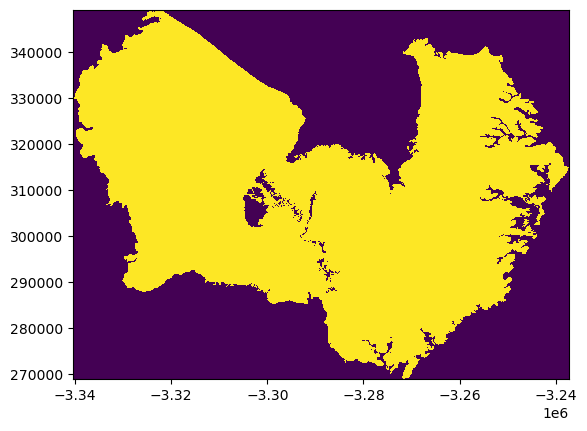

In [50]:
plt.pcolormesh(X_arr[x_min-1:x_max+1], Y_arr[y_min-1:y_max+1], template)

In [33]:
inversion = Inversion_inputs(gdf_list, urls)

In [37]:
inversion.data_dict['s3://its-live-data/datacubes/v2/N50W140/ITS_LIVE_vel_EPSG3413_G0120_X-3350000_Y350000.zarr']['zarr_store']

{'zarr_store': None,
 'dates_noinv': None,
 'A_m': None,
 'reg_mat_Inv': None,
 'mission': None,
 'index_sort': None,
 'inds_mission': None,
 'dates': None,
 'ind_tot': None,
 'valid_idx': None,
 'proj_cube': None,
 'mask_dates': None}

In [28]:
inversion.data_dict['s3://its-live-data/datacubes/v2/N50W130/ITS_LIVE_vel_EPSG3413_G0120_X-3350000_Y250000.zarr']['zarr_store']['mid_date'][:]


array([17334.35497882, 18259.35335869, 18997.36105568, ...,
       16750.85113548, 16669.85469784, 18643.84662629])

In [ ]:
data_dict[urls[url]]['zarr_store']

In [40]:
design_matrices_dict = inversion.design_matrices()

  0%|          | 0/4 [00:00<?, ?it/s]


NameError: name 'data_dict' is not defined

In [103]:
inversion.data_dict['s3://its-live-data/datacubes/v2/N50W130/ITS_LIVE_vel_EPSG3413_G0120_X-3350000_Y250000.zarr']['zarr_store']['mid_date']

TypeError: 'NoneType' object is not subscriptable

In [73]:
inversion.data_dict['s3://its-live-data/datacubes/v2/N50W130/ITS_LIVE_vel_EPSG3413_G0120_X-3350000_Y250000.zarr']

{'zarr_store': None,
 'dates_noinv': None,
 'A_m': None,
 'reg_mat_Inv': None,
 'mission': None,
 'index_sort': None,
 'inds_mission': None,
 'dates': None,
 'ind_tot': None,
 'valid_idx': None,
 'proj_cube': None,
 'mask_dates': None}

In [96]:
urls = inversion.mod_urls
for url in range(len(urls)):
    mid_dates = np.datetime64('1970-01-01') + np.array(inversion.data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')[inds_mission]

NameError: name 'inds_mission' is not defined

In [83]:
#mid_dates = np.datetime64('1970-01-01') + np.array(inversion.data_dict['s3://its-live-data/datacubes/v2/N50W130/ITS_LIVE_vel_EPSG3413_G0120_X-3350000_Y250000.zarr']['zarr_store']['mid_date'][:], dtype='timedelta64[D]')

inversion.data_dict['s3://its-live-data/datacubes/v2/N50W130/ITS_LIVE_vel_EPSG3413_G0120_X-3350000_Y250000.zarr']['zarr_store']


In [17]:
#| export 
def get_extents(url, gpdf, X_tot, Y_tot, X_valid, Y_valid, data_dict):# mission, lamb, derivative, day_interval):
    
    #url = input_data_dict['urls'].iloc[0]
    
    # Open the zarr files
    fs = s3fs.S3FileSystem(anon=True)
    store = zarr.open(s3fs.S3Map(url, s3=fs))
   
    # Update the dictionnary
    data_dict[url]['zarr_store'] = store

    # Get the cube's projection
    proj_cube = int(store.attrs['projection'])

    # Load X and Y of the dataset
    X = store['x'][:]
    Y = store['y'][:]

    # Store the arrays in the total list
    X_tot.append(X)
    Y_tot.append(Y)

    # Load dimensions
    shape_arr = store['v'].shape
    
    Xs, Ys = np.meshgrid(X, Y)
    points = np.array((Xs.flatten(), Ys.flatten())).T

    idx_valid = []
    
    for b in range(len(gpdf)):
        mpath = mplp.Path(list(gpdf[b]['geometry'].to_crs(np.int(proj_cube)).boundary.explode(index_parts = True).iloc[0].coords))
        glacier_mask = mpath.contains_points(points).reshape(Xs.shape)
        # Grab the indices of the points inside the glacier
        idx_valid.append(np.array(np.where(glacier_mask==True)))
        
    idx_valid = np.hstack(idx_valid)
    # Store the valid indices
    data_dict[url]['valid_idx'] = idx_valid
    
    # Store the cube projection
    data_dict[url]['proj_cube'] = proj_cube
    
    # Store the coordinates of the valid Xs and Ys
    X_valid.append([Xs[idx_valid[0][i], idx_valid[1][i]] for i in range(len(idx_valid[0]))])
    Y_valid.append([Ys[idx_valid[0][i], idx_valid[1][i]] for i in range(len(idx_valid[0]))])
    
    return X_tot, Y_tot, X_valid, Y_valid

In [18]:
#| export
def design_matrices(url, mission, lamb, derivative, day_interval, sdate, edate):

    # If you passed 'mission' as an argument, it grabs the appropriate values
    if mission:
        # Get the indices of the mission
        filt1 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img1'][:] == mission)
        filt2 = np.where(data_dict[urls[url]]['zarr_store']['satellite_img2'][:] == mission)
        inds_mission = np.intersect1d(filt1[0],filt2[0])

        # Grab only the indices corresponding to the missions
        mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')[inds_mission]
        im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')[inds_mission]
        im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')[inds_mission]
    else:
        # If 'None' was passed as a mission argument, we grab all the available data.
        inds_mission = None
        mid_dates = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]')
        im1 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img1'][:], dtype='timedelta64[D]')
        im2 = np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['acquisition_date_img2'][:], dtype='timedelta64[D]')
    
    # Get some arrays
    index_sort = np.argsort(np.datetime64('1970-01-01') + np.array(data_dict[urls[url]]['zarr_store']['mid_date'][:], dtype='timedelta64[D]'))
    mid_dates = mid_dates[index_sort]
    im1 = im1[index_sort]
    im2 = im2[index_sort]

    # If sdate is later than the first available date, we find its corresponding index
    try:
        sdate_ind = np.where(mid_dates >= sdate)[0][0]
    except:
        sdate_ind = 0
    
    # If edate is sooner than the last available date, we find its corresponding index
    try:
        edate_ind = np.where(mid_dates > edate)[0][0]
    except:
        edate_ind = None
    
    # Create a False/True mask where True if the date is in the desired range
    mask_dates = np.full(mid_dates.shape, False)
    mask_dates[sdate_ind:edate_ind] = True

    # Keep only the values within the desired range
    mid_dates = mid_dates[mask_dates]
    im1 = im1[mask_dates]
    im2 = im2[mask_dates]

    # Check which im is the smallest (first image, it changes depending on ITS_LIVE's version)
    if im2[0] < im1[0]:
        temp = im1
        im1 = im2
        im2 = temp

    # Create the date array with the new interval dates
    dates_nonum = np.arange(mid_dates[0], mid_dates[-1], timedelta(days=day_interval)).astype(np.datetime64)

    # Convert to numerical
    dates = (dates_nonum - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
    dt_start = (im1 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')
    dt_end = (im2 - np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')

    # --------------- DESIGN MATRICES --------------- 

    # Initialize matrix
    A_m = np.zeros((mid_dates.shape[0],dates.shape[0]))

    # We have to iterate through the satellite pairs that actually gave a measurement
    for j in range(1, len(mid_dates)):
    # current contents of your for loop

        # Find the middate that is the closest to dt_start (supequal)
        start = np.argmin(np.abs(dates-dt_start[j]))

        # Find the middate that is closest to dt_end (infequal)
        end = np.argmin(dt_end[j] - dates[dates <= dt_end[j]])

        # Divide 1 by the amount of middates between d_start and d_end 
        if end == A_m.shape[1]-1: # If the mid_date is at the end of the array (acquisition im2 equals last mid_date)
            A_m[j, start:] = 1/(1+A_m.shape[1]-start)
        else: # If the measurement is in A's bounds temporally (we can have a satellite pair with the 2nd pair being outside of our mid_dates)
            A_m[j, start:end+1] = 1/(1+end-start) # Attribute to each pixel in the timescale of the satellite pair, the 1/amount of pixel in the pairmid_dates.shape


    # Initialize regularization matrix
    if derivative == 1:
        reg_mat_Inv = np.zeros((A_m.shape[1] -1, A_m.shape[1]))

        for j in range(A_m.shape[1] -1):
            reg_mat_Inv[j, j] = -lamb/day_interval
            reg_mat_Inv[j, j+1] = lamb/day_interval

    elif derivative == 2:
        # Initialize 2nd derivative regularization matrix
        reg_mat_Inv = np.zeros((A_m.shape[1] -1, A_m.shape[1]))

        for j in range(A_m.shape[1] -2):
            reg_mat_Inv[j, j] = lamb/(day_interval**2)
            reg_mat_Inv[j, j+1] = -2*lamb/(day_interval**2)
            reg_mat_Inv[j, j+2] = lamb/(day_interval**2)
            
    data_dict[urls[url]]['A_m'] = A_m
    data_dict[urls[url]]['reg_mat_Inv'] = reg_mat_Inv
    data_dict[urls[url]]['mission'] = mission
    data_dict[urls[url]]['index_sort'] = index_sort
    data_dict[urls[url]]['inds_mission'] = inds_mission
    data_dict[urls[url]]['dates'] = dates_nonum
    data_dict[urls[url]]['dates_noinv'] = mid_dates
    data_dict[urls[url]]['mask_dates']= mask_dates
            
    return data_dict

In [19]:
#| export
def Inv_reg(vObs, data, fillvalue):
    
    # Grab observed velocities
    vObs = vObs[data['index_sort']]
    vObs = vObs[data['mask_dates']]
    
    # Filter out the missions we don't want
    if mission:
        vObs = vObs[data['inds_mission']]  
    
    # Mask the NaNs so we don't compute the inversion for empty rows
    mask = np.logical_not(np.equal(vObs, fillvalue))
    
    # Create a masked velocity vector
    vObs_masked = vObs[mask]
    
    # Append regularization terms to dObs
    vObs_masked= np.hstack((vObs_masked, np.zeros((data['reg_mat_Inv'].shape[0]))))
     
    # Assemble the design matrix
    A_des = np.vstack((data['A_m'][mask], data['reg_mat_Inv']))
    
    # Invert the velocities
    vInv = np.linalg.solve(A_des.T@A_des,A_des.T@vObs_masked)
    #vInv = scipy.linalg.solve(A_des.T@A_des,A_des.T@vObs_masked, lower = False, check_finite=False, assume_a='gen')
    
    return vInv


In [20]:
#| export 
try:
    data_dict, X_valid, Y_valid, X_tot, Y_tot = create_data_dict(urls)

    for url in tqdm(range(len(urls))):
        X_tot, Y_tot, X_valid, Y_valid = get_extents(urls[url], gpdf_ls, X_tot, Y_tot, X_valid, Y_valid, data_dict)

    mission = None # 'None' if you want all the data, 'S1' for Sentinel-1 only, 'L' for Landsat only, etc.. .
    lamb = 10 # Smoothing coefficient: the higher the value, the more the inversion favors a smooth output. BAD for surging glaciers, GOOD for non-surging glaciers
    derivative = 2 # Derivative degree for the inversion. Doesn't change much unless you have a specific reasong to choose 1 or 2 (1st or 2nd derivative)
    day_interval = 12 # Amount of days in between each inversion value. The higher, the faster the inversion. But you also lose in temporal resolution. 12 here because Sentinel-1 repeat-time is 12.
    sdate = None # Start date, format 'YYYY-MM-DD' OR None if you want to grab the entire timeseries available
    edate = None # End date, format 'YYYY-MM-DD' OR None if you want to grab the entire timeseries available
    GPU = True # None if you want to run it on CPU

    # Create Eastings and Northings arrays based on the Eastings and Northings of the datacubes
    X_arr = np.unique(np.hstack(X_tot))
    Y_arr = np.unique(np.hstack(Y_tot))
    
    # Crop to the GOI (so we avoid over-filling our matrix with NaNs)
    x_min = np.where(np.min(np.hstack(X_valid)) == X_arr)[0][0]
    x_max = np.where(np.max(np.hstack(X_valid)) == X_arr)[0][0]
    y_min = np.where(np.min(np.hstack(Y_valid)) == Y_arr)[0][0]
    y_max = np.where(np.max(np.hstack(Y_valid)) == Y_arr)[0][0]
    
    
    # And now search the indices corresponding to the coordinates 
    x_matches = np.hstack([[np.where(i == X_arr[min(x_min-1, x_max+1):max(x_min-1, x_max+1)])[0][0] for i in row] for row in X_valid]).astype(int)
    y_matches = np.hstack([[np.where(i == Y_arr[min(y_min-1, y_max+1):max(y_min-1, y_max+1)])[0][0] for i in row] for row in Y_valid]).astype(int)
    
    # Create an array representing the glacier
    template = np.zeros((len(Y_arr[min(y_min-1, y_max+1):max(y_min-1, y_max+1)]), len( X_arr[min(x_min-1, x_max+1):max(x_min-1, x_max+1)])))
    template[y_matches, x_matches] = 1
except:
    pass

In [21]:
try:
    plt.pcolormesh(X_arr[x_min-1:x_max+1], Y_arr[y_min-1:y_max+1], template)
except:
    pass

In [22]:
#| export
try:

    for i in tqdm(range(len(urls))):
        design_matrices(i, mission, lamb, derivative, day_interval)
except:
    pass

  0%|          | 0/1 [00:00<?, ?it/s]


### Gather the dates for each datacube. They might not always correspond.

In [23]:
#| export
try:
    # Get the total amount of temporal steps
    ind_tot = []
    for i in urls:
        ind_tot.append(data_dict[i]['dates'])
    
    ind_tot = np.unique(np.hstack(ind_tot))
    
    for i in urls:
        data_dict[i]['ind_tot'] = np.array([np.where(c == ind_tot)[0][0] for c in data_dict[urls[0]]['dates']])
except:
    pass

### Calculate the point-inversion for all the GOI pixels in the datacubes for Vx and Vy.

In [24]:
#| export
if GPU:

    import torch

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    '''
    # Migrate to torch & GPU
    for c in range(len(urls)):
        data_dict[urls[c]]['A_m'] = torch.from_numpy(data_dict[urls[c]]['A_m']).to(device)
        data_dict[urls[c]]['reg_mat_Inv'] = torch.from_numpy(data_dict[urls[c]]['reg_mat_Inv']).to(device)
    '''
    
    def Inv_reg_torch(vObs, data, fillvalue, device):
     
        # Grab observed velocities
        vObs = vObs[data['index_sort']]
        vObs = vObs[data['mask_dates']]
        
        # Filter out the missions we don't want
        if mission:
            vObs = vObs[data['inds_mission']]  
        
        # Mask the NaNs so we don't compute the inversion for empty rows
        mask = np.logical_not(np.equal(vObs, fillvalue))
        
        # Create a masked velocity vector
        vObs_masked = torch.from_numpy(vObs[mask])
        
        # Append regularization terms to dObs
        vObs_masked= torch.hstack((vObs_masked, torch.zeros((data['reg_mat_Inv'].shape[0])))).to(device)
         
        # Assemble the design matrix
        A_des = torch.vstack((data['A_m'][mask], data['reg_mat_Inv']))
        
        # Invert the velocities
        vInv = torch.linalg.solve(A_des.T@A_des,A_des.T@vObs_masked.double())
        
        return vInv
    
    vxInv = torch.zeros((len(ind_tot), template.shape[0], template.shape[1])).double().to(device)
    vyInv = torch.zeros((vxInv.shape)).double().to(device)
    
    # Define the total number of iterations
    total_iterations = len(y_matches)
    
    # Create a tqdm object with dynamic_ncols=False to suppress intermediate updates
    # Create a tqdm object with a larger mininterval to suppress intermediate updates
    progress_bar = tqdm(total=total_iterations, dynamic_ncols=False, mininterval=1.0)
    
    
    i = 0
    for c in range(len(urls)):
        valid_idx = data_dict[urls[c]]['valid_idx']
        fillvx = data_dict[urls[c]]['zarr_store']['vx'][:, valid_idx[0][0], valid_idx[1][0]].min() #data_dict[urls[c]]['zarr_store']['vx'].fill_value   fill_value is wrong in the new ITS_LIVE version
        fillvy = data_dict[urls[c]]['zarr_store']['vx'][:, valid_idx[0][0], valid_idx[1][0]].min() #data_dict[urls[c]]['zarr_store']['vy'].fill_value
    
        for V in range(len(valid_idx[0])):
            vxObs = data_dict[urls[c]]['zarr_store']['vx'][:, valid_idx[0][V], valid_idx[1][V]]
            vyObs = data_dict[urls[c]]['zarr_store']['vy'][:, valid_idx[0][V], valid_idx[1][V]]
            vxInv[data_dict[urls[c]]['ind_tot'], y_matches[i], x_matches[i]] = Inv_reg_torch(vxObs, data_dict[urls[c]], fillvx, device)
            vyInv[data_dict[urls[c]]['ind_tot'], y_matches[i], x_matches[i]] = Inv_reg_torch(vyObs, data_dict[urls[c]], fillvy, device)
            
            i += 1
            progress_bar.update(1)  # Update the progress bar

            if i%100 == 0:
                with open("Counter.txt", "w") as text_file:
                    text_file.write(f"Counter: {i}")
            
            if i%5000 == 0:
                
                print(f"Saved at {i}")
                # Get the names of all the glaciers in the datacube 
                #glac_names = np.hstack(np.array([glacier.id.values[0] for glacier in gdf_list]))
                #glac_names = '-'.join(glac_names)

                # Gather the projection of the cube
                #glac_proj = str(np.unique(np.hstack([data_dict[urls[i]]['proj_cube'] for i in range(len(urls))]))[0])

                # Create a new dataset with vx and vy, using attributes from 'ds'
                new_ds = xr.Dataset(
                    {
                        "vx": (["time", "y", "x"], vxInv.cpu().numpy()),
                        "vy": (["time", "y", "x"], vyInv.cpu().numpy()),
                    },
                    coords={
                        "time": ind_tot,
                        "x": X_arr[x_min-1:x_max+1],
                        "y": Y_arr[y_min-1:y_max+1],
                    },
                    attrs=data_dict[urls[0]]['zarr_store'].attrs,
                ).chunk({'time': 1, 'x': 100, 'y': 100})

                from dask.diagnostics import ProgressBar
                write_job = new_ds.to_netcdf(f'Inverted_Cube.nc', compute=False)
                with ProgressBar():
                    print(f"Writing to {'Inverted_Cube.nc'}")
                    write_job.compute()
    
    # Close the progress bar
    progress_bar.close()

    # Save the dataset
    new_ds = xr.Dataset(
        {
            "vx": (["time", "y", "x"], vxInv.cpu().numpy()),
            "vy": (["time", "y", "x"], vyInv.cpu().numpy()),
        },
        coords={
            "time": ind_tot,
            "x": X_arr[x_min-1:x_max+1],
            "y": Y_arr[y_min-1:y_max+1],
        },
        attrs=data_dict[urls[0]]['zarr_store'].attrs,
    ).chunk({'time': 1, 'x': 100, 'y': 100})
    
    from dask.diagnostics import ProgressBar
    write_job = new_ds.to_netcdf(f'VelInv.nc', compute=False)
    with ProgressBar():
        print(f"Writing to {'VelInv.nc'}")
        write_job.compute()



else:
    
    vxInv = np.zeros((len(ind_tot), template.shape[0], template.shape[1]))
    vyInv = np.zeros((vxInv.shape))
    
    # Define the total number of iterations
    total_iterations = len(y_matches)
    
    # Create a tqdm object with dynamic_ncols=False to suppress intermediate updates
    # Create a tqdm object with a larger mininterval to suppress intermediate updates
    progress_bar = tqdm(total=total_iterations, dynamic_ncols=False, mininterval=1.0)
    
    
    i = 0
    for c in range(len(urls)):
        valid_idx = data_dict[urls[c]]['valid_idx']
        fillvx = data_dict[urls[c]]['zarr_store']['vx'][:, valid_idx[0][0], valid_idx[1][0]].min() #data_dict[urls[c]]['zarr_store']['vx'].fill_value   fill_value is wrong in the new ITS_LIVE version
        fillvy = data_dict[urls[c]]['zarr_store']['vx'][:, valid_idx[0][0], valid_idx[1][0]].min() #data_dict[urls[c]]['zarr_store']['vy'].fill_value
        
        for V in range(len(valid_idx[0])):
            vxObs = data_dict[urls[c]]['zarr_store']['vx'][:, valid_idx[0][V], valid_idx[1][V]]
            vyObs = data_dict[urls[c]]['zarr_store']['vy'][:, valid_idx[0][V], valid_idx[1][V]]
            vxInv[data_dict[urls[c]]['ind_tot'], y_matches[i], x_matches[i]] = Inv_reg(vxObs, data_dict[urls[c]], fillvx)
            vyInv[data_dict[urls[c]]['ind_tot'], y_matches[i], x_matches[i]] = Inv_reg(vyObs, data_dict[urls[c]], fillvy)
            
            i += 1
            if i%100 == 0:
                with open("Counter.txt", "w") as text_file:
                    text_file.write(f"Counter: {i}")
            
            if i%10000 == 0:
                
                print(f"Saved at {i}")
                # Get the names of all the glaciers in the datacube 
                #glac_names = np.hstack(np.array([glacier.id.values[0] for glacier in gdf_list]))
                #glac_names = '-'.join(glac_names)

                # Gather the projection of the cube
                #glac_proj = str(np.unique(np.hstack([data_dict[urls[i]]['proj_cube'] for i in range(len(urls))]))[0])

                # Create a new dataset with vx and vy, using attributes from 'ds'
                new_ds = xr.Dataset(
                    {
                        "vx": (["time", "y", "x"], vxInv),
                        "vy": (["time", "y", "x"], vyInv),
                    },
                    coords={
                        "time": ind_tot,
                        "x": X_arr[x_min-1:x_max+1],
                        "y": Y_arr[y_min-1:y_max+1],
                    },
                    attrs=data_dict[urls[0]]['zarr_store'].attrs,
                ).chunk({'time': 1, 'x': 100, 'y': 100})

                from dask.diagnostics import ProgressBar
                write_job = new_ds.to_netcdf(f'Inverted_Cube.nc', compute=False)
                with ProgressBar():
                    print(f"Writing to {'Inverted_Cube.nc'}")
                    write_job.compute()
            progress_bar.update(1)  # Update the progress bar
    
    # Close the progress bar
    progress_bar.close()

    # Save the dataset
    new_ds = xr.Dataset(
        {
            "vx": (["time", "y", "x"], vxInv),
            "vy": (["time", "y", "x"], vyInv),
        },
        coords={
            "time": ind_tot,
            "x": X_arr[x_min-1:x_max+1],
            "y": Y_arr[y_min-1:y_max+1],
        },
        attrs=data_dict[urls[0]]['zarr_store'].attrs,
    ).chunk({'time': 1, 'x': 100, 'y': 100})

    from dask.diagnostics import ProgressBar
    write_job = new_ds.to_netcdf(f'Inverted_Cube.nc', compute=False)
    with ProgressBar():
        print(f"Writing to {'Inverted_Cube.nc'}")
        write_job.compute()

NameError: name 'GPU' is not defined

### Save the results in a netcdf file

In [32]:
#| export
# Create a new dataset with vx and vy, using attributes from 'ds'
try:
    new_ds = xr.Dataset(
        {
            "vx": (["time", "y", "x"], vxInv),
            "vy": (["time", "y", "x"], vyInv),
        },
        coords={
            "time": ind_tot,
            "x": X_arr[x_min-1:x_max+1],
            "y": Y_arr[y_min-1:y_max+1],
        },
        attrs=data_dict[urls[0]]['zarr_store'].attrs,
    ).chunk({'time': 1, 'x': 100, 'y': 100})
    
    from dask.diagnostics import ProgressBar
    write_job = new_ds.to_netcdf('Inverted_Cube.nc', compute=False)
    with ProgressBar():
        print(f"Writing to {'Inverted_Cube.nc'}")
        write_job.compute()
except:
    pass

In [33]:
try: 
    test = xr.open_dataset('Inverted_Cube.nc')
except:
    pass